In [68]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [69]:
def derivative(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

In [70]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [71]:
EPOCHS = 10000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3

In [72]:
model = PINN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
MSE_LOSS = nn.MSELoss()

In [73]:
num_pde_points = 10000

def PDE_loss():
    x = (torch.rand(num_pde_points, 1, requires_grad=True)*2 - 1).to(DEVICE)
    t = (torch.rand(num_pde_points, 1, requires_grad=True)).to(DEVICE)
    points = torch.cat([t, x], dim=1).to(DEVICE)
    
    v = 0.01/np.pi # viscosity
    
    u = model(points)
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    mse = MSE_LOSS(v*u_xx, u_t + u*u_x)
    return mse
PDE_loss()

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)

In [74]:
num_boundary_points = 25
num_initial_condition_points = 50

t_x_boundary_condition_1 = torch.cat([torch.linspace(0, 1, num_boundary_points).view(-1, 1), -1*torch.ones(num_boundary_points, 1)], dim=1)
t_x_boundary_condition_2 = torch.cat([torch.linspace(0, 1, num_boundary_points).view(-1, 1), torch.ones(num_boundary_points, 1), ], dim=1)
t_x_initial_condition = torch.cat([torch.zeros(num_initial_condition_points, 1), torch.linspace(-1, 1, num_initial_condition_points).view(-1, 1)], dim=1)

u_boundary_condition_1 = torch.zeros(num_boundary_points, 1)
u_boundary_condition_2 = torch.zeros(num_boundary_points, 1)
u_initial_condition = -torch.sin(np.pi*t_x_initial_condition[:, 1]).view(-1, 1)

all_input_points = torch.cat([t_x_boundary_condition_1, t_x_boundary_condition_2, t_x_initial_condition], dim=0).to(DEVICE)
all_output_points = torch.cat([u_boundary_condition_1, u_boundary_condition_2, u_initial_condition], dim=0).to(DEVICE)

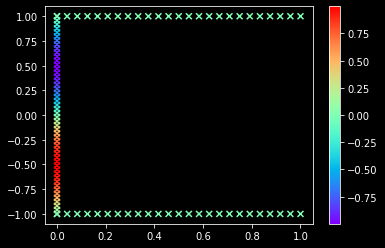

In [75]:
# plotting ground truth values

plt.scatter(all_input_points[:, 0].cpu().detach(), all_input_points[:, 1].cpu().detach(), marker='x', c=all_output_points.cpu().detach(), cmap='rainbow')
plt.colorbar()

Epoch: 5000, Loss: 0.006864
0.0046970779076218605 0.0021668612025678158


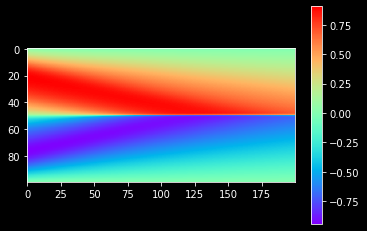

Epoch: 10000, Loss: 0.001992
0.0012797057861462235 0.0007120988448150456


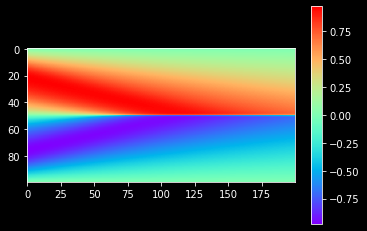

In [76]:
model.train()
loop = tqdm(range(EPOCHS), total=EPOCHS, leave=False)
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    pde_loss = PDE_loss()
    
    ground_truth_loss = MSE_LOSS(model(all_input_points), all_output_points)
    
    loss = pde_loss + ground_truth_loss
    
    loss.backward()
    optimizer.step()

    loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
    if (epoch+1) % 5000 == 0:
        
        
        print("Epoch: %d, Loss: %f" % (epoch+1, loss.item()))
        print(pde_loss.item(), ground_truth_loss.item())
        
        
        
        mesh = np.meshgrid(np.linspace(0, 1, 200), np.linspace(-1, 1, 100))
        mesh_x, mesh_y = mesh[0], mesh[1]
        mesh = np.array([mesh_x, mesh_y], dtype=np.float32)
        plt.imshow(model(torch.from_numpy(mesh).permute(1,2,0).to(DEVICE)).cpu().detach(), cmap='rainbow')
        plt.colorbar()
        plt.show()

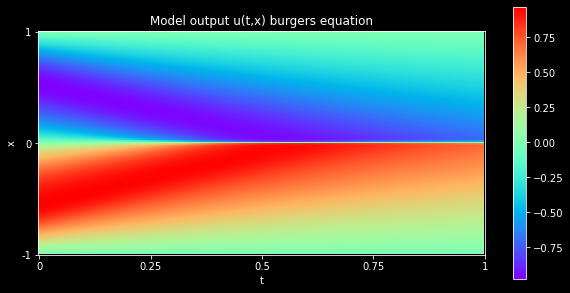

In [77]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
mesh = np.meshgrid(np.linspace(0, 1, 200), np.linspace(-1, 1, 100))
mesh_x, mesh_y = mesh[0], mesh[1]
mesh = np.array([mesh_x, -mesh_y], dtype=np.float32)
plt.imshow(model(torch.from_numpy(mesh).permute(1,2,0).to(DEVICE)).cpu().detach(), cmap='rainbow')
plt.colorbar()
_ = plt.title('Model output u(t,x) burgers equation')
_ = plt.xlabel('t')
_ = plt.ylabel('x')
_ = plt.xticks([0, 50, 100, 150, 200], [0, 0.25, 0.5, 0.75, 1])
_ = plt.yticks([0, 50, 100], [1, 0, -1])

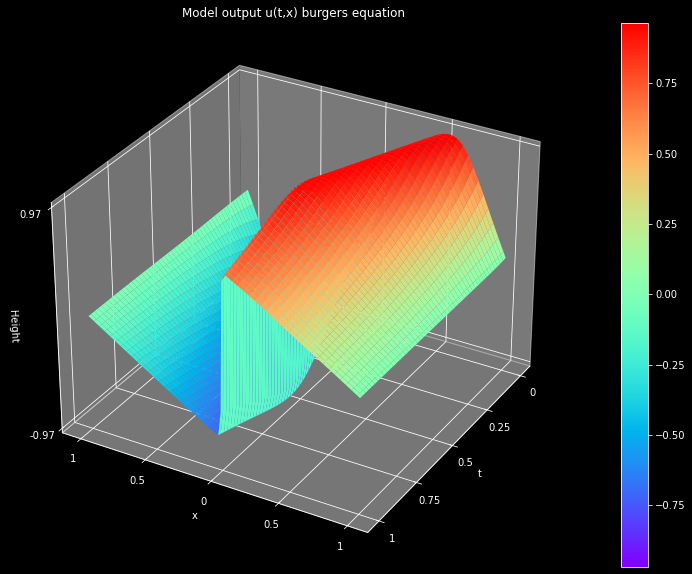

In [87]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

plt.style.use('dark_background')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

mesh = np.meshgrid(np.linspace(0, 1, 200), np.linspace(-1, 1, 100))
mesh_x, mesh_y = mesh[0], mesh[1]
mesh = np.array([mesh_x, -mesh_y], dtype=np.float32)

input_data = np.stack((mesh_x, -mesh_y), axis=-1)
input_data = input_data.reshape(-1, 2)

input_data = torch.from_numpy(input_data).to('cuda')

input_data = input_data.float()
height_data = model(input_data).cpu().detach().numpy()
height_data = height_data.reshape(100, 200)

surf = ax.plot_surface(mesh_x, mesh_y, height_data, cmap='rainbow')

fig.colorbar(surf)

ax.set_title('Model output u(t,x) burgers equation')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('Height')

ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([np.min(height_data), np.max(height_data)])

ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels([1, 0.5, 0, 0.5, 1])
ax.set_zticklabels([f'{np.min(height_data):.2f}', f'{np.max(height_data):.2f}'])
ax.view_init(30, 30)
plt.show()
